In [47]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import scipy.stats as spicystats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from statsmodels.discrete.discrete_model import Logit
from statsmodels.discrete.discrete_model import Logit
from statsmodels.discrete.discrete_model import LogitResults
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.insert(0, 'src/')
import functions
from sklearn.metrics import confusion_matrix
import seaborn as sn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
## data cleaning
df = pd.read_csv('../data/lending_club_loan_dataset.csv')
df.drop('last_major_derog_none', axis=1, inplace=True)
df.drop('grade', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.dropna(inplace=True)
df.replace({' 36 months': '36 months', ' 36 Months': '36 months', ' 60 months': '60 months'}, inplace=True)
df['revol_util'].sort_values(ascending=False).head(5)
df = df[df['revol_util'] <= 200]
df['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE'], dtype=object)

In [49]:
## adding dummy variables for categorical features
df_dummies = pd.get_dummies(df, columns=['home_ownership', 'purpose', 'term'])

In [50]:
## Prediction model for good/bad loan
## logistic regression

X = df_dummies.drop('bad_loan', axis=1)
y = df_dummies['bad_loan']
randomseed=8
X.drop(['home_ownership_MORTGAGE', 'purpose_debt_consolidation', 'term_60 months'], axis=1, inplace=True)

X_data, X_holdout, y_data, y_holdout = train_test_split(X, y, test_size=0.2, random_state=randomseed, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=randomseed, stratify=y_data)
data_list = [X_train, X_test, X_holdout]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_holdout = scaler.fit_transform(X_holdout)
X

,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,home_ownership_OWN,home_ownership_RENT,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months
0,100000.0,1,1,26.27,1,43.2,0.0,0.160624,0,1,...,0,0,0,0,0,0,0,0,0,1
1,83000.0,0,4,5.39,0,21.5,0.0,0.810777,1,0,...,0,0,0,0,0,0,0,0,0,1
2,78000.0,0,11,18.45,1,46.3,0.0,0.035147,0,0,...,0,0,0,0,0,0,0,0,0,0
3,37536.0,0,6,12.28,0,10.7,0.0,0.534887,0,0,...,0,0,0,1,0,0,0,0,0,0
4,65000.0,0,11,11.26,0,15.2,0.0,0.166500,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,27000.0,0,9,18.36,1,46.5,0.0,0.821782,0,1,...,0,0,0,0,0,0,0,0,0,1
19996,45000.0,0,2,23.22,0,46.2,0.0,0.652200,0,0,...,0,0,1,0,0,0,0,0,0,1
19997,104000.0,0,5,13.27,1,78.5,0.0,0.482555,0,0,...,0,0,0,0,0,0,0,0,0,1
19998,38400.0,0,2,12.84,0,47.4,0.0,0.822980,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
lst = []

for i in np.linspace(0.1, 0.9, num=9):
    log_model = LogisticRegression(random_state=randomseed, penalty='l2', C=1, max_iter=200).fit(X_train, y_train)
    y_probs = log_model.predict_proba(X_test)
    threshold = i
    predictions = np.where(y_probs[:,1] >= threshold, 1, 0)
    lst.append(metrics.f1_score(y_test, predictions))
np.max(lst)

0.4082979726544083

In [52]:
log_model2 = Logit(y_train, X_train).fit()
log_model2.predict(X_test)
log_model2.summary()

Optimization terminated successfully.
         Current function value: 0.471620
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               bad_loan   No. Observations:                11022
Model:                          Logit   Df Residuals:                    11000
Method:                           MLE   Df Model:                           21
Date:                Mon, 06 Feb 2023   Pseudo R-squ.:                 0.05861
Time:                        15:16:10   Log-Likelihood:                -5198.2
converged:                       True   LL-Null:                       -5521.8
Covariance Type:            nonrobust   LLR p-value:                1.829e-123
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -11.2151      0.781    -14.353      0.000     -12.747      -9.684
x2            -0.1644      0.088     -1.860      0.063      -0.338       0.009
x3            -0.5932      0.081     -7.313      0.000      -0.752      -0.434
x4             0.5299      0.106      4.982      0.000       0.321       0.738
x5            -0.0688      0.049     -1.419      0.156      -0.164       0.026
x6             0.5204      0.117      4.432      0.000       0.290       0.751
x7             8.9951      0.939      9.577      0.000       7.154      10.836
x8            -0.2873      0.081     -3.543      0.000      -0.446      -0.128
x9            -0.1010      0.092     -1.103      0.270      -0.280       0.079
x10            0.1426      0.052      2.743      0.006       0.041       0.245
x11           -0.4453      0.319     -1.396      0.163      -1.071       0.180
x12           -0.2818      0.065     -4.329      0.000      -0.409      -0.154
x13            0.0820      0.116      0.708      0.479      -0.145       0.309
x14           -0.7930      0.480     -1.653      0.098      -1.733       0.147
x15            0.2733      0.184      1.482      0.138      -0.088       0.635
x16            0.1202      0.260      0.462      0.644      -0.389       0.630
x17            0.1935      0.276      0.700      0.484      -0.348       0.735
x18            0.3548      0.105      3.394      0.001       0.150       0.560
x19            0.8016      0.193      4.158      0.000       0.424       1.179
x20            0.1218      0.314      0.388      0.698      -0.493       0.737
x21            0.1866      0.370      0.504      0.614      -0.539       0.912
x22           -0.9974      0.050    -19.969      0.000      -1.095      -0.900
==============================================================================
"""

In [53]:
# fig, ax = plt.subplots()

# penalty_range = np.logspace(-3, 0.5, base=10)
# threshold_range = [1, 2, 3]

# for idx, val in enumerate(threshold_range):
#     dict1 = {}
#     for j in np.logspace(-2, 0.5, base=10):
#         log_model = LogisticRegression(random_state=randomseed, penalty='l2', C=j).fit(X_train, y_train)
#         y_probs = log_model.predict_proba(X_test)
#         threshold = (val/10)
#         predictions = np.where(y_probs[:,1] >= threshold, 1, 0)
#         dict1[j] = metrics.f1_score(y_test, predictions)

#     max_value = np.max([k for k in dict1.values()])
#     max_key = [key for key, value in dict1.items() if value == max_value]
#     print(f'Penalty: {max_key[0]}, Threshold: {threshold}')
    
#     ax.plot(dict1.keys(), dict1.values(), label=f'Threshold Value: {val/10} | Max: {max_value: .2f}')
# ax.legend()
# ax.set_xlabel('Penalty Value')
# ax.set_ylabel('F1 Score')
# fig.tight_layout()
# fig.set_size_inches(8, 4)

0.3 2.6826957952797246 13310000


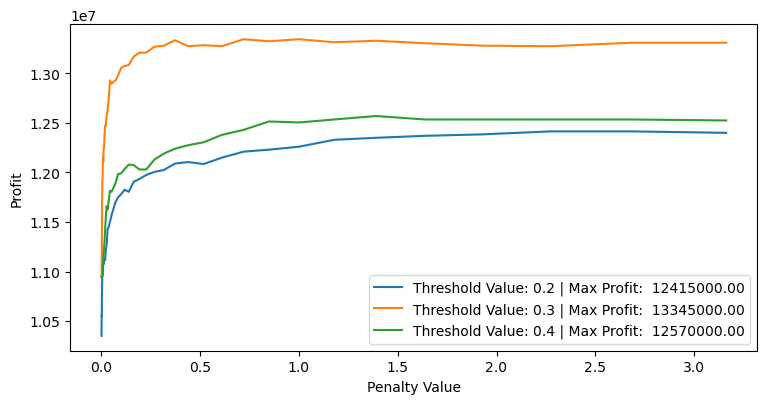

In [54]:
# running multiple thresholds and penalty values to produce best logistic regression model

max_threshold, max_penalty, max_profit = functions.best_log_model(  X_train, X_test, y_train, y_test, \
                                                                    threshold_range=[2, 3, 4], \
                                                                    penalty_range=np.logspace(-3, 0.5, base=10), \
                                                                    profit_matrix=[[10000, 0], [-25000, 0]])
print(max_threshold, max_penalty, max_profit)

In [55]:
log_model = LogisticRegression(random_state=randomseed, penalty='l2', C=max_penalty).fit(X_train, y_train)
y_probs = log_model.predict_proba(X_test)
threshold = max_threshold
predictions = np.where(y_probs[:,1] >= threshold, 1, 0)

In [56]:
cm_model = confusion_matrix(y_test, predictions)
print(cm_model)
tn, fp, fn, tp = cm_model.ravel()
print(tn, fp, fn, tp)

[[2666  271]
 [ 534  203]]
2666 271 534 203


In [57]:
sum(sum(cm_model))

3674

In [58]:
profit_matrix = [[10000, 0], [-25000, 0]]
np.zeros(3674)
np.ones(3674)

cm_no_loans = confusion_matrix(y_test, np.ones(3674))
print(cm_no_loans)
cm_all_loans = confusion_matrix(y_test, np.zeros(3674))
print(cm_all_loans)

profit_using_model = sum(sum(cm_model * profit_matrix))
profit_no_loans = sum(sum(cm_no_loans * profit_matrix))
profit_all_loans = sum(sum(cm_all_loans * profit_matrix))

print(profit_using_model, profit_no_loans, profit_all_loans)

model_performance_df = pd.DataFrame({   'Profit': [f'${profit_no_loans:,.0f}', \
                                        f'${profit_all_loans:,.0f}', f'${profit_using_model:,.0f}']}, \
                                        index=['No Loans Given', 'All Loans Given',
                                        'Model Prediction'])

model_performance_df

[[   0 2937]
 [   0  737]]
[[2937    0]
 [ 737    0]]
13310000 0 10945000


,Profit
No Loans Given,$0
All Loans Given,"$10,945,000"
Model Prediction,"$13,310,000"


Text(50.722222222222214, 0.5, 'True')

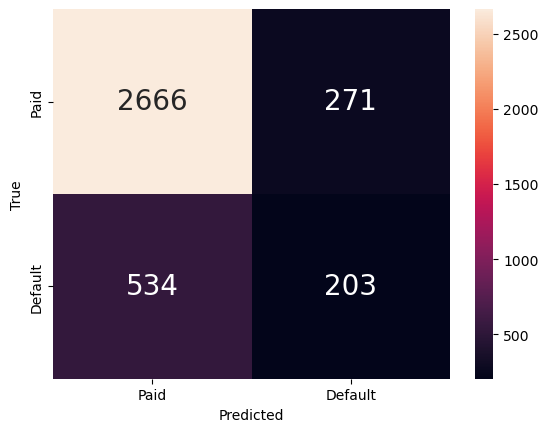

In [59]:
fig, ax = plt.subplots()

df_cm = pd.DataFrame(cm_model)
sn.heatmap( df_cm, annot=True, annot_kws={"size": 20}, fmt='.4g', \
            xticklabels=['Paid', 'Default'], yticklabels=['Paid', 'Default'])
# sn.heatmap()
ax.set_xlabel('Predicted')
ax.set_ylabel('True')